<a href="https://colab.research.google.com/github/LongNguyen1984/TimeSeriesWithPython/blob/main/RulefitExample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Install RuleFit

In [2]:
pip install rulefit

  Created wheel for rulefit: filename=rulefit-0.3.1-cp37-none-any.whl size=7818 sha256=b94bb4bbade1e82404e105cf640569bfdbc41a386056dcca3a34d3f35544151d
  Stored in directory: /root/.cache/pip/wheels/13/12/5e/edb7c06b9514897b2d697a825db0281031cf47ac0843bba42c
Successfully built rulefit


In [3]:
## Xóa cảnh báo
import warnings
warnings.filterwarnings('ignore')

# Thư viện hỗ trợ
import numpy as np
import pandas as pd
import itertools

# Đồ họa
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
# Thư viện xgboost
from xgboost import XGBClassifier # XGboost

plt.rcParams.update({'font.size': 13})
np.random.seed(123)

# Xuất hình vector SVG
%config InlineBackend.figure_format = 'png'

from rulefit import RuleFit

import matplotlib

##Data preparation

In [9]:
df = pd.read_csv('https://raw.githubusercontent.com/kinokoberuji/Statistics-Python-Tutorials/master/heart_disease.csv', sep = ';')

df['ST_slope'] = df['ST_slope'].map({0: 'Normal',
                                     1: 'Upsloping',
                                     2: 'Flat', 
                                     3: 'Downsloping'})

df['Chest_pain'] = df['Chest_pain'].map({1: 'typical_angina',
                                         2: 'atypical_angina',
                                         3: 'non-anginal_pain',
                                         4: 'asymptomatic',})

df['Rest_ECG'] = df['Rest_ECG'].map({0 : 'Normal',
                                     1: 'ST_T_abnormal',
                                     2: 'LV_hypertrophy',})

df = pd.get_dummies(df, drop_first=False)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1190 entries, 0 to 1189
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Age                          1190 non-null   int64  
 1   Sex                          1190 non-null   int64  
 2   Rest_BP                      1190 non-null   int64  
 3   Cholesterol                  1190 non-null   int64  
 4   FBS                          1190 non-null   int64  
 5   Max_HR                       1190 non-null   int64  
 6   Exc_angina                   1190 non-null   int64  
 7   Oldpeak                      1190 non-null   float64
 8   Target                       1190 non-null   int64  
 9   Chest_pain_asymptomatic      1190 non-null   uint8  
 10  Chest_pain_atypical_angina   1190 non-null   uint8  
 11  Chest_pain_non-anginal_pain  1190 non-null   uint8  
 12  Chest_pain_typical_angina    1190 non-null   uint8  
 13  Rest_ECG_LV_hypert

Chia dữ liệu gốc thành lập Train và Test với tỉ lệ 70/30

In [10]:
X_train, X_test, y_train,y_test = train_test_split(df.drop(['Target'], axis = 1),
                                                   df['Target'],
                                                   test_size=0.3,
                                                   random_state=123,)

###So sánh RuleFit và những mô hình cây tập hợp khác

In [11]:
class_models = {#1 Decision Tree
    'Decision_tree':{'model': DecisionTreeClassifier(max_depth=3,
                                                     random_state=123)
                    },
    #RF
    'Random_Forest':{'model': \
                     RandomForestClassifier(max_depth=5,
                                            n_estimators = 200,
                                            class_weight='balanced',
                                            random_state=123)
                    },
    # XGboost
    'XGBoost': {'model': XGBClassifier(booster='dart',
                                       learning_rate = 0.05,
                                       gamma = 0.5,
                                       n_estimators = 200,
                                       reg_alpha = 0,
                                       reg_lambda = 1.5,
                                       subsample = 0.33,
                                       colsample_bytree = 0.8,
                                       tree_method = "gpu_hist",
                                       gpu_id = 0,
                                       max_depth = 5,
                                       min_child_weight = 5,
                                       eval_metric = 'logloss',
                                       predictor = 'gpu_predictor')
               },
    #RuleFit
    'Rule_fit': {'model': RuleFit(tree_size = 4,
                                   max_rules=100,
                                   rfmode='classify', 
                                   lin_standardise=True,
                                   lin_trim_quantile=0.025,
                                   exp_rand_tree_size=True,
                                  
                                  tree_generator=GradientBoostingClassifier(learning_rate=0.01,
                                                  max_depth=100,
                                                  max_leaf_nodes=5,
                                                  n_estimators=100,
                                                  random_state=123,
                                                  subsample=0.33),
                                  
                                    random_state=123)}, 
                }

In [12]:
for model_name in class_models.keys():
    
    if model_name == 'Rule_fit':
        fitted_model = class_models[model_name]['model'].fit(X_train.values, 
                                                             y_train.values, 
                                                             X_test.columns)
        y_train_pred = fitted_model.predict(X_train.values)
        y_test_pred = fitted_model.predict(X_test.values)
        
    else:
        fitted_model = class_models[model_name]['model'].fit(X_train, y_train)
        y_train_pred = fitted_model.predict(X_train)
        y_test_pred = fitted_model.predict(X_test)
        
    class_models[model_name]['fitted'] = fitted_model
    class_models[model_name]['preds'] = y_test_pred
    class_models[model_name]['BAC_train'] = balanced_accuracy_score(y_train, y_train_pred)
    class_models[model_name]['BAC_test'] = balanced_accuracy_score(y_test, y_test_pred)
    class_models[model_name]['Precision_train'] = precision_score(y_train, y_train_pred)
    class_models[model_name]['Precision_test'] = precision_score(y_test, y_test_pred)
    class_models[model_name]['Recall_train'] = recall_score(y_train, y_train_pred)
    class_models[model_name]['Recall_test'] = recall_score(y_test, y_test_pred)
    class_models[model_name]['F1_train'] = f1_score(y_train, y_train_pred)
    class_models[model_name]['F1_test'] = f1_score(y_test, y_test_pred)

In [13]:
class_metrics = pd.DataFrame.from_dict(class_models, 'index')[['BAC_train', 'BAC_test',\
                                                               'Precision_train', 'Precision_test',\
                                                               'Recall_train', 'Recall_test',\
                                                               'F1_train', 'F1_test']]
class_metrics.sort_values(by='F1_test', ascending=False).style.\
    background_gradient(cmap='Spectral_r', low=0.5, high=0.1, subset=['BAC_train','BAC_test',\
                                                                 'Recall_train', 'Recall_test',\
                                                                 'Precision_train', 'Precision_test',\
                                                                 'F1_train', 'F1_test'])

,BAC_train,BAC_test,Precision_train,Precision_test,Recall_train,Recall_test,F1_train,F1_test
Random_Forest,0.896824,0.864175,0.903614,0.885167,0.890736,0.889423,0.897129,0.887290
XGBoost,0.907617,0.867982,0.913462,0.900498,0.902613,0.870192,0.908005,0.885086
Rule_fit,0.848722,0.832021,0.850356,0.857143,0.850356,0.865385,0.850356,0.861244
Decision_tree,0.843095,0.805579,0.869898,0.849246,0.809976,0.812500,0.838868,0.830467


###Khai Thác mô hình Random Forest

In [19]:
def show_values_on_bars(axs, h_v="v", space=0.4):
        
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width()/2
                _y = p.get_y() + p.get_height()
                value = int(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height()
                value = round(float(p.get_width()),3)
                ax.text(_x, _y, value, ha = 'left')

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

In [20]:
rf_mod = class_models['Random_Forest']['fitted']

vimp_df = pd.DataFrame({'importance': rf_mod.feature_importances_}, 
                       index=X_test.columns)

vimp_df.sort_values(by="importance", ascending=False, inplace = True)

vimp_df.style.\
    background_gradient(cmap='Spectral_r', low=0.0, high=0.2, subset=['importance'])

,importance
ST_slope_Upsloping,0.180532
Chest_pain_asymptomatic,0.133389
Exc_angina,0.125365
Oldpeak,0.110361
ST_slope_Flat,0.105516
Max_HR,0.088096
Cholesterol,0.059007
Age,0.049370
Sex,0.035393
Rest_BP,0.029438


In [21]:
rf_mod = class_models['Random_Forest']['fitted']

vimp_df = pd.DataFrame({'importance': rf_mod.feature_importances_}, 
                       index=X_test.columns)

vimp_df.sort_values(by="importance", ascending=False, inplace = True)

vimp_df.style.\
    background_gradient(cmap='Spectral_r', low=0.0, high=0.2, subset=['importance'])

,importance
ST_slope_Upsloping,0.180532
Chest_pain_asymptomatic,0.133389
Exc_angina,0.125365
Oldpeak,0.110361
ST_slope_Flat,0.105516
Max_HR,0.088096
Cholesterol,0.059007
Age,0.049370
Sex,0.035393
Rest_BP,0.029438


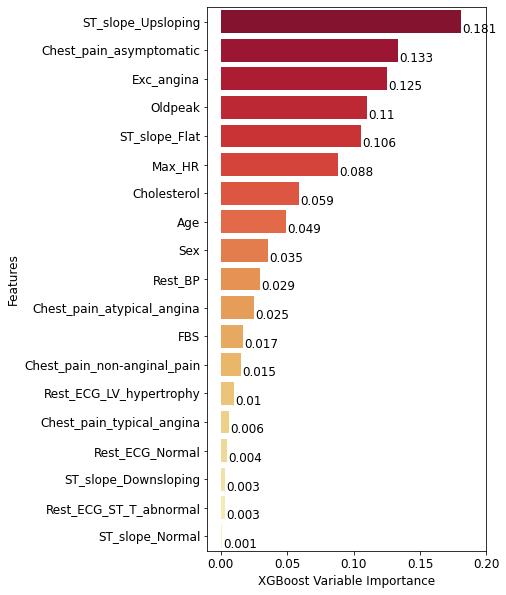

In [22]:
plt.figure(figsize=(5,10))

sns.set_palette(sns.color_palette("YlOrRd_r", vimp_df.shape[0]).as_hex())

matplotlib.rcParams.update({'font.size': 12})
ax = sns.barplot(x = vimp_df.importance, y = vimp_df.index)

show_values_on_bars(ax, h_v="h", space=0.001)
plt.xlabel('XGBoost Variable Importance')
plt.xlim([-0.01,0.2])
plt.ylabel('Features')
        
plt.show()

### Khai thác mô hình XGboost

In [24]:
xgb_mod = class_models['XGBoost']['fitted']

vimp_df = pd.DataFrame({'importance': xgb_mod.feature_importances_}, 
                       index=X_test.columns)

vimp_df.sort_values(by="importance", ascending=False, inplace = True)

vimp_df.style.\
    background_gradient(cmap='Spectral_r', low=0.0, high=0.2, subset=['importance'])

AttributeError: ignored

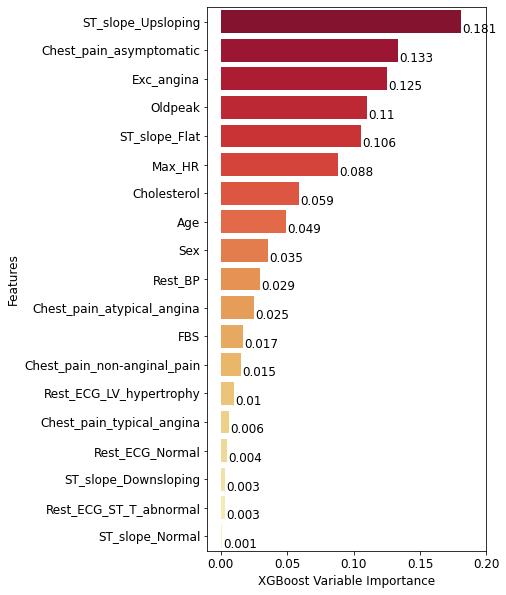

In [25]:
plt.figure(figsize=(5,10))

sns.set_palette(sns.color_palette("YlOrRd_r", vimp_df.shape[0]).as_hex())

matplotlib.rcParams.update({'font.size': 12})
ax = sns.barplot(x = vimp_df.importance, y = vimp_df.index)

show_values_on_bars(ax, h_v="h", space=0.001)
plt.xlabel('XGBoost Variable Importance')
plt.xlim([-0.01,0.2])
plt.ylabel('Features')
        
plt.show()

### Khai thác mô hình RuleFit

In [26]:
rulefit_df = class_models['Rule_fit']['fitted'].get_rules()

rulefit_df = rulefit_df[rulefit_df.coef != 0.].sort_values(by="importance", ascending=False)

rulefit_df.style.\
    background_gradient(cmap='Spectral_r', low=0.2, high=0.5, subset=['importance']).\
    background_gradient(cmap='rainbow', low=-0.5, high=0., subset=['coef'])

,rule,type,coef,support,importance
60,Exc_angina <= 0.5 & Cholesterol > 132.5,rule,-0.959886,0.518248,0.479623
56,ST_slope_Upsloping <= 0.5 & Sex > 0.5,rule,0.799684,0.427007,0.395558
46,ST_slope_Upsloping <= 0.5 & Chest_pain_typical_angina <= 0.5 & Max_HR <= 150.5,rule,0.716771,0.372263,0.346493
8,Chest_pain_asymptomatic,linear,0.414614,1.000000,0.207300
53,ST_slope_Upsloping > 0.5 & Oldpeak <= 1.199999988079071,rule,-0.229535,0.401460,0.112517
35,Chest_pain_asymptomatic <= 0.5,rule,-0.217717,0.489051,0.108832
44,Chest_pain_asymptomatic <= 0.5 & ST_slope_Flat <= 0.5,rule,-0.203978,0.332117,0.096068
70,ST_slope_Upsloping > 0.5 & Cholesterol > 154.0,rule,-0.174120,0.412409,0.085714
25,Chest_pain_asymptomatic > 0.5,rule,0.169766,0.510949,0.084862
67,Chest_pain_asymptomatic <= 0.5 & ST_slope_Upsloping > 0.5 & Oldpeak <= 1.75,rule,-0.132152,0.302920,0.060727


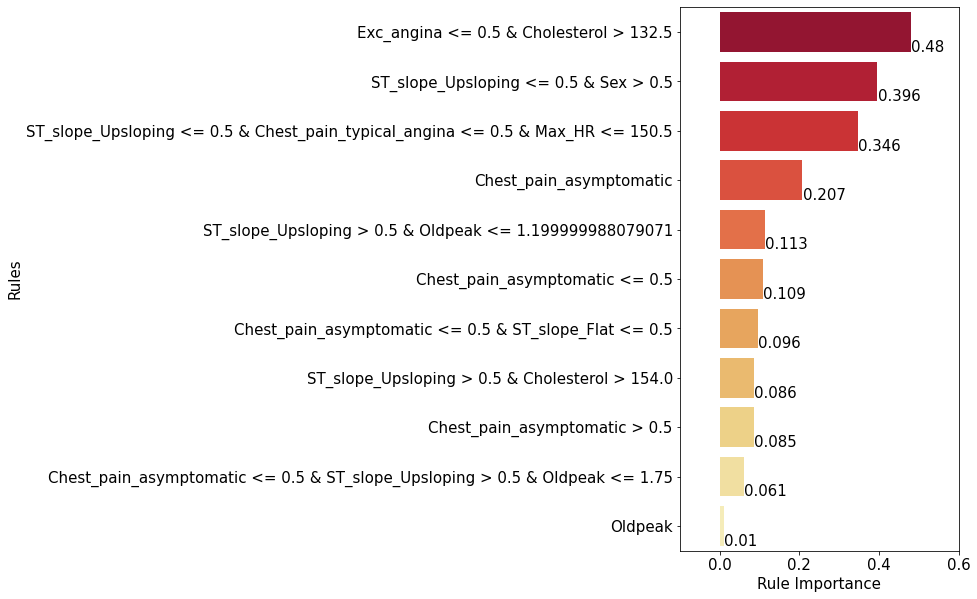

In [27]:
plt.figure(figsize=(5,10))

sns.set_palette(sns.color_palette("YlOrRd_r", 
                                  rulefit_df.shape[0]).as_hex())

matplotlib.rcParams.update({'font.size': 15})

ax = sns.barplot(x = rulefit_df.importance, 
                 y = rulefit_df.rule)

show_values_on_bars(ax, h_v="h", 
                    space=0.001)

plt.xlabel('Rule Importance')
plt.xlim([-0.1,0.6])
plt.ylabel('Rules')

plt.show()